<a href="https://colab.research.google.com/github/Auhre/Ecommerce-Fraud-Detection/blob/main/Ecommerce_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ecommerce Fraud Detection with RNN together with GAN

[Ecommerce Dataset](https://www.kaggle.com/datasets/shriyashjagtap/fraudulent-e-commerce-transactions)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
data = pd.read_csv('fraud-ecomm.csv')
data

,Transaction ID,Customer ID,Transaction Amount,Transaction Date,Payment Method,Product Category,Quantity,Customer Age,Customer Location,Device Used,IP Address,Shipping Address,Billing Address,Is Fraudulent,Account Age Days,Transaction Hour
0,15d2e414-8735-46fc-9e02-80b472b2580f,d1b87f62-51b2-493b-ad6a-77e0fe13e785,58.09,2024-02-20 05:58:41,bank transfer,electronics,1,17,Amandaborough,tablet,212.195.49.198,Unit 8934 Box 0058\nDPO AA 05437,Unit 8934 Box 0058\nDPO AA 05437,0,30,5
1,0bfee1a0-6d5e-40da-a446-d04e73b1b177,37de64d5-e901-4a56-9ea0-af0c24c069cf,389.96,2024-02-25 08:09:45,debit card,electronics,2,40,East Timothy,desktop,208.106.249.121,"634 May Keys\nPort Cherylview, NV 75063","634 May Keys\nPort Cherylview, NV 75063",0,72,8
2,e588eef4-b754-468e-9d90-d0e0abfc1af0,1bac88d6-4b22-409a-a06b-425119c57225,134.19,2024-03-18 03:42:55,PayPal,home & garden,2,22,Davismouth,tablet,76.63.88.212,"16282 Dana Falls Suite 790\nRothhaven, IL 15564","16282 Dana Falls Suite 790\nRothhaven, IL 15564",0,63,3
3,4de46e52-60c3-49d9-be39-636681009789,2357c76e-9253-4ceb-b44e-ef4b71cb7d4d,226.17,2024-03-16 20:41:31,bank transfer,clothing,5,31,Lynnberg,desktop,207.208.171.73,"828 Strong Loaf Apt. 646\nNew Joshua, UT 84798","828 Strong Loaf Apt. 646\nNew Joshua, UT 84798",0,124,20
4,074a76de-fe2d-443e-a00c-f044cdb68e21,45071bc5-9588-43ea-8093-023caec8ea1c,121.53,2024-01-15 05:08:17,bank transfer,clothing,2,51,South Nicole,tablet,190.172.14.169,"29799 Jason Hills Apt. 439\nWest Richardtown, ...","29799 Jason Hills Apt. 439\nWest Richardtown, ...",0,158,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1472947,c8604004-2f4c-42ce-a1c4-cd2bebca79bb,f8a534ad-0458-465e-a85b-3ad2cdf391bc,208.48,2024-01-12 23:39:55,PayPal,health & beauty,2,29,North Laurafort,desktop,27.245.104.92,USNV Griffin\nFPO AA 52700,USNV Griffin\nFPO AA 52700,0,149,23
1472948,fff0df19-fd4a-42a5-bc42-64bb7b02edb0,f2ef2239-d9b9-40d0-9993-4b8f305d5a7b,231.57,2024-03-27 04:31:45,credit card,clothing,2,32,Burnsville,tablet,203.54.50.163,"478 John Square Apt. 235\nMillerhaven, GA 68797","478 John Square Apt. 235\nMillerhaven, GA 68797",0,132,4
1472949,9e79012f-e00b-47d1-8700-0c302db20d3e,fa5b9a25-9606-478a-8abe-ef20bbb3980f,101.80,2024-01-31 23:51:42,bank transfer,electronics,4,36,Garciafort,mobile,51.241.30.149,"351 Frazier Radial Apt. 989\nPort Charles, OH ...","182 House Island Suite 198\nEast Scott, FM 84301",0,98,23
1472950,917066b1-4dfb-4472-b3f0-292663c45d21,04524272-e14f-460b-bc70-5316bd28463d,61.80,2024-01-12 16:21:32,bank transfer,electronics,5,34,Lake Josephberg,desktop,210.67.203.4,"27307 Gonzalez Shore Suite 661\nPort Lynn, WV ...","27307 Gonzalez Shore Suite 661\nPort Lynn, WV ...",0,191,16


In [ ]:
class DataPreprocessor():
  def __init__(self, data):
    self.data = data

  def reorder(self, data):
    cols = list(data.columns)
    cols.remove(self.target_col)
    cols.append(self.target_col)
    reordered_data = data[cols]
    return reordered_data

  def clean(self, droplist, target_col):
    self.data.drop(droplist, axis=1, inplace=True)
    self.target_col = target_col
    self.data.dropna(inplace=True)
    self.cleaned_data = self.reorder(self.data)
    return self.cleaned_data

  def sanity_check_clean(self):
    print('-------------------------------')
    print('Target Column Value Check:')
    print('-------------------------------')
    print(self.cleaned_data[self.target_col].value_counts())
    print('-------------------------------')
    print('Null Column Value Check:')
    print('-------------------------------')
    print(self.cleaned_data.isnull().sum())

  def fit_transform(self, data):
    data = self.reorder(data)
    categorical_features = data.select_dtypes(include=['object', 'boolean']).columns
    numerical_features = data.select_dtypes(include=['int64', 'float64']).columns
    categorical_data = data[categorical_features]
    numerical_data = data[numerical_features]
    self.num_features_shape = numerical_data.shape[1]
    self.all_columns_list = list(categorical_data.columns) + list(numerical_data.columns)
    preprocessor = ColumnTransformer(
        [
            ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features),
            ('minmax', MinMaxScaler(), numerical_features)
        ],
        remainder='passthrough'
    )
    self.pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor)
    ])
    self.pipeline.fit(data)
    transformed_data = self.pipeline.transform(data)
    return transformed_data

  def sanity_check_transform(self):
    print('-------------------------------')
    print('Order of Column Check:')
    print('-------------------------------')
    print(self.all_columns_list)

  def inverse_transform(self, data):
    column_transformer = self.pipeline.named_steps['preprocessor']
    num_transformer = column_transformer.named_transformers_['minmax']
    cat_transformer = column_transformer.named_transformers_['onehot']
    generated_num = num_transformer.inverse_transform(data[:, -self.num_features_shape:])
    generated_num[:, :-1] = np.round(generated_num[:, :-1])

    generated_num[generated_num[:, :] < 0] = 0

    generated_cat = cat_transformer.inverse_transform(data[:, 0: data.shape[1] - self.num_features_shape])
    combined_data = np.concatenate((generated_cat, generated_num), axis=1)

    df = pd.DataFrame(combined_data, columns=self.all_columns_list[:len(combined_data[0])])
    return combined_data, df

  def transform(self, data):
    transformed_data = self.pipeline.transform(data)
    return transformed_data

In [ ]:
data['Transaction Date'] = pd.to_datetime(data['Transaction Date'])
data['Day of Week'] = data['Transaction Date'].dt.dayofweek
data['Day of Week'] = data['Day of Week'].astype(int)
data['Billing Shipping Address Match'] = data['Billing Address'] == data['Shipping Address']
data['Billing Shipping Address Match'] = data['Billing Shipping Address Match'].astype(int)

In [ ]:
dp = DataPreprocessor(data)

In [ ]:
cleaned_data = dp.clean(
    droplist=['Transaction ID', 'Customer ID', 'IP Address', 'Billing Address', 'Shipping Address', 'Customer Location', 'Transaction Date'],
    target_col='Is Fraudulent')
cleaned_data.head(15)

,Transaction Amount,Payment Method,Product Category,Quantity,Customer Age,Device Used,Account Age Days,Transaction Hour,Day of Week,Billing Shipping Address Match,Is Fraudulent
0,58.09,bank transfer,electronics,1,17,tablet,30,5,1,1,0
1,389.96,debit card,electronics,2,40,desktop,72,8,6,1,0
2,134.19,PayPal,home & garden,2,22,tablet,63,3,0,1,0
3,226.17,bank transfer,clothing,5,31,desktop,124,20,5,1,0
4,121.53,bank transfer,clothing,2,51,tablet,158,5,0,1,0
5,166.41,bank transfer,toys & games,2,34,tablet,38,10,1,0,0
6,92.88,PayPal,toys & games,2,14,tablet,119,19,6,1,0
7,318.14,credit card,health & beauty,4,42,desktop,251,13,1,1,0
8,47.92,bank transfer,home & garden,4,38,desktop,190,19,6,1,0
9,121.78,bank transfer,health & beauty,4,39,mobile,343,21,1,1,0


In [ ]:
dp.sanity_check_clean()

-------------------------------
Target Column Value Check:
-------------------------------
Is Fraudulent
0    1399114
1      73838
Name: count, dtype: int64
-------------------------------
Null Column Value Check:
-------------------------------
Transaction Amount                0
Payment Method                    0
Product Category                  0
Quantity                          0
Customer Age                      0
Device Used                       0
Account Age Days                  0
Transaction Hour                  0
Day of Week                       0
Billing Shipping Address Match    0
Is Fraudulent                     0
dtype: int64


In [ ]:
transformed_data = dp.fit_transform(cleaned_data)
transformed_data

array([[0.        , 1.        , 0.        , ..., 0.16666667, 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        0.        ],
       [1.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.        , 1.        , 0.        , ..., 0.33333333, 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.66666667, 1.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 1.        ,
        0.        ]])

In [ ]:
dp.sanity_check_transform()

-------------------------------
Order of Column Check:
-------------------------------
['Payment Method', 'Product Category', 'Device Used', 'Transaction Amount', 'Quantity', 'Customer Age', 'Account Age Days', 'Transaction Hour', 'Day of Week', 'Billing Shipping Address Match', 'Is Fraudulent']


In [ ]:
quantity_index = len(cleaned_data['Payment Method'].unique()) + len(cleaned_data['Product Category'].unique()) + len(cleaned_data['Device Used'].unique()) + 1
quantity_index

13

# GAN

In [ ]:
class Generator(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(Generator, self).__init__()
    self.fc1 = nn.Linear(input_dim, 128)
    self.fc2 = nn.Linear(128, 256)
    self.fc3 = nn.Linear(256, output_dim)
    self.leaky_relu = nn.LeakyReLU(0.2)
    self.tanh = nn.Tanh()
  def forward(self, z):
    x = self.leaky_relu(self.fc1(z))
    x = self.leaky_relu(self.fc2(x))
    x = self.tanh(self.fc3(x))
    return x

class Discriminator(nn.Module):
  def __init__(self, input_dim):
    super(Discriminator, self).__init__()
    self.fc1 = nn.Linear(input_dim, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 1)
    self.leaky_relu = nn.LeakyReLU(0.2)
    self.sigmoid = nn.Sigmoid()
  def forward(self, z):
    x = self.leaky_relu(self.fc1(z))
    x = self.leaky_relu(self.fc2(x))
    x = self.sigmoid(self.fc3(x))
    return x

In [ ]:
class GAN():
  def __init__(self, input_dim, output_dim, latent_dim):
    self.generator = Generator(input_dim, output_dim)
    self.discriminator = Discriminator(output_dim)
    self.latent_dim = latent_dim

  def train(self, data, num_epochs=10, batch_size=64, lr=0.0002):
    criterion = nn.BCELoss()
    d_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=lr)
    g_optimizer = torch.optim.Adam(self.generator.parameters(), lr=lr)
    real_dataset = TensorDataset(torch.tensor(data, dtype=torch.float32))
    real_dataloader = DataLoader(real_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    for epoch in range(num_epochs):
      for real_data in real_dataloader:
        real_data = real_data[0].clone().detach()
        z = torch.randn(batch_size, self.latent_dim)
        fake_data = self.generator(z)
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)
        d_optimizer.zero_grad()
        real_output = self.discriminator(real_data)
        d_real_loss = criterion(real_output, real_labels)
        fake_output = self.discriminator(fake_data.detach())
        d_fake_loss = criterion(fake_output, fake_labels)
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        g_optimizer.zero_grad()
        z = torch.randn(batch_size, self.latent_dim)
        fake_data = self.generator(z)
        fake_output = self.discriminator(fake_data)
        g_loss = criterion(fake_output, real_labels)
        g_loss.backward()
        g_optimizer.step()
      print(f'Epoch [{epoch+1}/{num_epochs}], D_loss: {d_loss.item()}, G_loss: {g_loss.item()}')

  def generate(self, num_samples=100):
    random_noise = torch.randn(num_samples, self.latent_dim)
    self.generator.eval()
    with torch.no_grad():
      synthetic_data = self.generator(random_noise)
    return synthetic_data

In [ ]:
gan = GAN(input_dim=100, output_dim=transformed_data.shape[1], latent_dim=100)
gan.train(data=transformed_data, num_epochs=5, batch_size=64, lr=0.0001)

Epoch [1/5], D_loss: 0.6931710243225098, G_loss: 2.8254547119140625
Epoch [2/5], D_loss: 0.5230245590209961, G_loss: 2.5386338233947754
Epoch [3/5], D_loss: 0.2673794627189636, G_loss: 3.897660732269287
Epoch [4/5], D_loss: 0.17651015520095825, G_loss: 4.716405868530273
Epoch [5/5], D_loss: 0.1386243849992752, G_loss: 7.711724281311035


In [ ]:
constructed_data = gan.generate(num_samples=3000000)
constructed_data

tensor([[-4.8001e-03,  9.9999e-01, -6.9821e-03,  ...,  9.0904e-01,
          9.9987e-01,  2.0564e-03],
        [ 9.9999e-01, -4.4853e-03, -2.2347e-04,  ...,  9.9951e-01,
          1.0000e+00, -3.9197e-03],
        [ 1.0000e+00,  1.5728e-02,  9.3706e-03,  ...,  9.8429e-01,
          1.0000e+00, -3.3905e-04],
        ...,
        [ 2.6225e-01,  8.5692e-01,  7.0211e-03,  ...,  9.8289e-01,
          1.0000e+00, -4.3650e-03],
        [ 8.3166e-01,  1.3709e-03,  1.7287e-01,  ...,  3.8786e-02,
          7.1498e-01, -2.8907e-03],
        [-2.5121e-02, -1.4935e-02,  1.0000e+00,  ...,  2.7423e-02,
          1.0000e+00,  5.4314e-03]])

In [ ]:
constructed_data = constructed_data[constructed_data[:, quantity_index] > 0]
len(constructed_data)

2923739

In [ ]:
class GANBinaryClassBalancer():
  def __init__(self, original_data, processed_data, synthetic_data, target_col):
    self.synthetic_data = synthetic_data
    self.processed_data = processed_data
    self.real_false_counts = original_data[target_col].value_counts()[0]
    self.real_true_counts = original_data[target_col].value_counts()[1]
    self.synthetic_data[:, -1] = torch.where(self.synthetic_data[:, -1] <= 0, torch.tensor(0), torch.tensor(1))

  def balance_class(self, class_balancer_num):
    self.class_balancer_num = class_balancer_num
    self.synthetic_true = self.synthetic_data[self.synthetic_data[:, -1] == 1]
    self.synthetic_true = self.synthetic_true[:self.class_balancer_num - self.real_true_counts, :]
    self.synthetic_false = self.synthetic_data[self.synthetic_data[:, -1] == 0]
    self.synthetic_false = self.synthetic_false[:self.class_balancer_num - self.real_false_counts, :]
    self.balancer_synthetic_data = torch.cat((self.synthetic_true, self.synthetic_false), dim=0)
    extended_data = np.concatenate((self.processed_data, self.balancer_synthetic_data), axis=0)
    return extended_data

  def sanity_check(self):
    print('Completed balancing both classes with {0} entries'.format(self.class_balancer_num))
    print('Aditional synthetic true: {0}'.format(self.synthetic_true.shape[0]))
    print('Aditional synthetic false: {0}'.format(self.synthetic_false.shape[0]))
    print('Unique value check for synthetic true: {0}'.format(self.synthetic_true[:, -1].unique()))
    print('Unique value check for synthetic false: {0}'.format(self.synthetic_false[:, -1].unique()))

In [ ]:
sb = GANBinaryClassBalancer(cleaned_data, transformed_data, constructed_data, 'Is Fraudulent')
transformed_balanced_fraud_dataset = sb.balance_class(1500000)
sb.sanity_check()

Completed balancing both classes with 1500000 entries
Aditional synthetic true: 1344857
Aditional synthetic false: 100886
Unique value check for synthetic true: tensor([1.])
Unique value check for synthetic false: tensor([0.])


In [ ]:
transformed_balanced_fraud_dataset.shape

(2918695, 20)

In [ ]:
extended_fraud_data, extended_fraud_df = dp.inverse_transform(transformed_balanced_fraud_dataset)
extended_fraud_df['Is Fraudulent'].value_counts()

,count
Is Fraudulent,
0.0,1500000
1.0,1418695


In [ ]:
extended_fraud_df

,Payment Method,Product Category,Device Used,Transaction Amount,Quantity,Customer Age,Account Age Days,Transaction Hour,Day of Week,Billing Shipping Address Match,Is Fraudulent
0,bank transfer,electronics,tablet,58.0,1.0,17.0,30.0,5.0,1.0,1.0,0.0
1,debit card,electronics,desktop,390.0,2.0,40.0,72.0,8.0,6.0,1.0,0.0
2,PayPal,home & garden,tablet,134.0,2.0,22.0,63.0,3.0,0.0,1.0,0.0
3,bank transfer,clothing,desktop,226.0,5.0,31.0,124.0,20.0,5.0,1.0,0.0
4,bank transfer,clothing,tablet,122.0,2.0,51.0,158.0,5.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2918690,credit card,electronics,tablet,187.0,3.0,43.0,328.0,16.0,6.0,1.0,0.0
2918691,PayPal,health & beauty,mobile,111.0,5.0,54.0,59.0,0.0,6.0,1.0,0.0
2918692,PayPal,health & beauty,desktop,107.0,5.0,42.0,269.0,5.0,3.0,1.0,0.0
2918693,credit card,electronics,tablet,106.0,2.0,37.0,191.0,20.0,5.0,1.0,0.0


In [ ]:
def plot_feature_distribution(df, col):
  plt.figure(figsize=(5, 5))
  sns.histplot(df[col], bins=40)
  plt.title('Distribution of {0} in the Extended Fraud Dataset by GAN'.format(col))
  plt.xlabel(col)
  plt.ylabel('Frequency')
  plt.show()

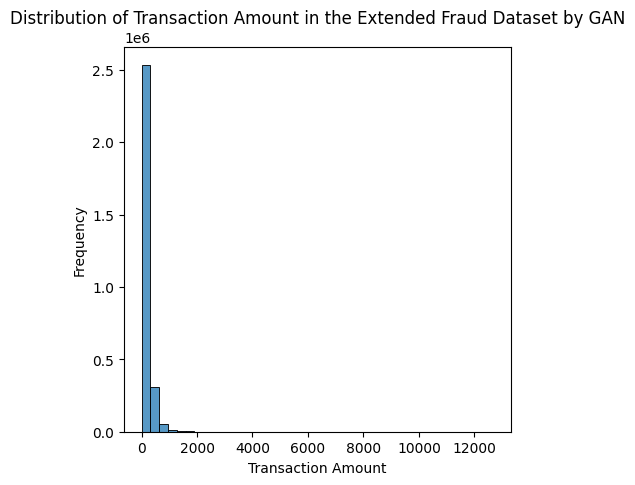

In [ ]:
plot_feature_distribution(extended_fraud_df, 'Transaction Amount')

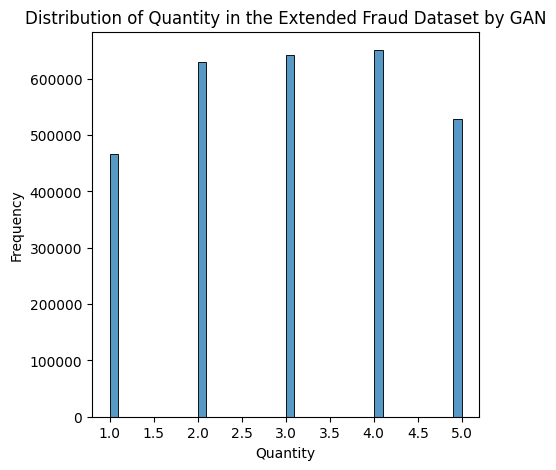

In [ ]:
plot_feature_distribution(extended_fraud_df, 'Quantity')

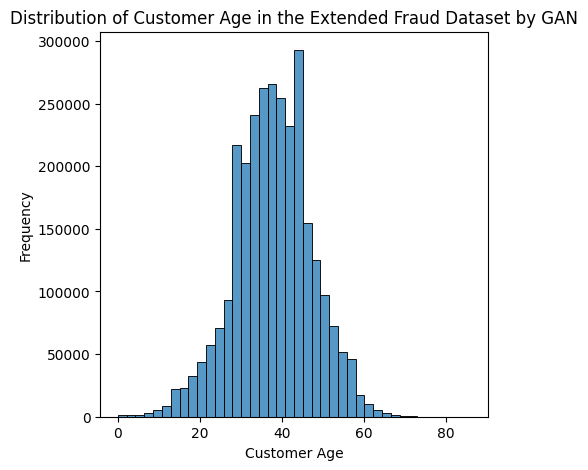

In [ ]:
plot_feature_distribution(extended_fraud_df, 'Customer Age')

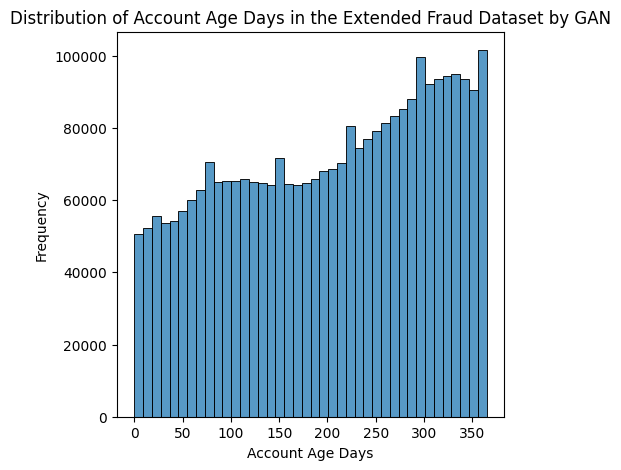

In [ ]:
plot_feature_distribution(extended_fraud_df, 'Account Age Days')

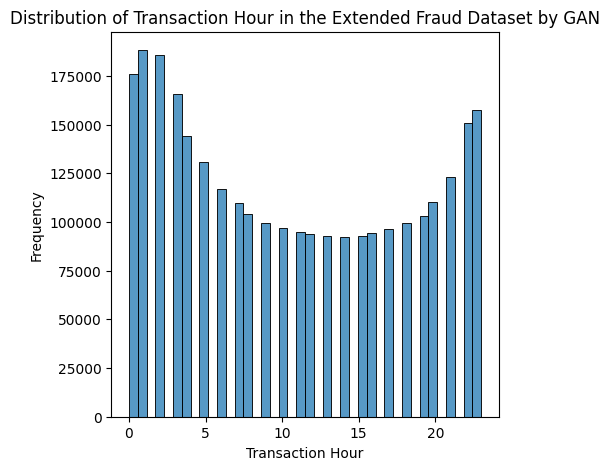

In [ ]:
plot_feature_distribution(extended_fraud_df, 'Transaction Hour')

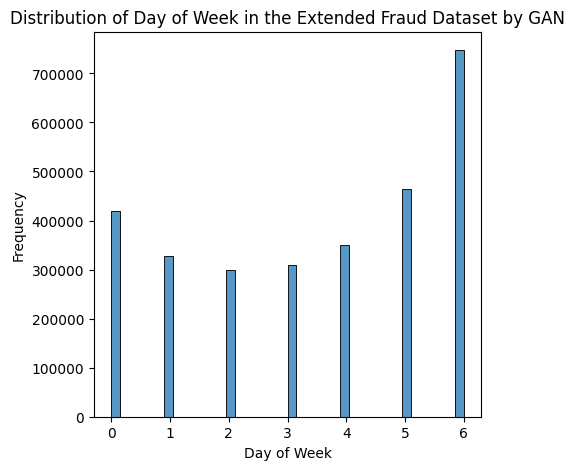

In [ ]:
plot_feature_distribution(extended_fraud_df, 'Day of Week')

### LSTM for fraud detection


In [ ]:
class FraudDetectionModel():
  def __init__(self, data):
    self.data = data

  def train_test_split(self, test_size=0.3, random_state=42):
    self.X = self.data[:, :-1]
    self.y = self.data[:, -1]
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=test_size, random_state=random_state)

  def build(self):
    self.model = Sequential()
    self.model.add(Input(shape=(self.X_train.shape[1], 1)))
    self.model.add(LSTM(64, return_sequences=True))
    self.model.add(Dropout(0.2))
    self.model.add(LSTM(64, return_sequences=False))
    self.model.add(Dropout(0.2))
    self.model.add(Dense(1, activation='sigmoid'))
    self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  def train(self, epochs=5, batch_size=64, validation_split=0.2):
    early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
    self.history = self.model.fit(self.X_train, self.y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stop])

  def plot_loss(self):
    plt.plot(self.history.history['loss'], label='Training Loss')
    plt.plot(self.history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

  def evaluate(self):
    self.loss, self.accuracy = self.model.evaluate(self.X_test, self.y_test)
    print('Test Loss:', self.loss)
    print('Test Accuracy:', self.accuracy)

  def input_info(self, jsondata):
    print('-------------------------------')
    print('FEATURE INPUTS GUIDE')
    print('-------------------------------')
    print('Payment Method')
    print('-------------------------------')
    for e in jsondata['Payment Method']:
      print(e)
    print('-------------------------------')
    print('Product Category')
    print('-------------------------------')
    for e in jsondata['Product Category']:
      print(e)
    print('-------------------------------')
    print('Device Used')
    print('-------------------------------')
    for e in jsondata['Device Used']:
      print(e)
    print('-------------------------------')
    print('Billing Shipping Address Match')
    print('-------------------------------')
    for e in jsondata['Billing Shipping Address Match']:
      print(e)
    print('-------------------------------')
    print('Transaction Amount')
    print('-------------------------------')
    print('{0} - {1}'.format(jsondata['Transaction Amount'][0], jsondata['Transaction Amount'][1]))
    print('-------------------------------')
    print('Quantity')
    print('-------------------------------')
    print('{0} - {1}'.format(jsondata['Quantity'][0], jsondata['Quantity'][1]))
    print('-------------------------------')
    print('Customer Age')
    print('-------------------------------')
    print('{0} - {1}'.format(jsondata['Customer Age'][0], jsondata['Customer Age'][1]))
    print('-------------------------------')
    print('Account Age Days')
    print('-------------------------------')
    print('{0} - {1}'.format(jsondata['Account Age Days'][0], jsondata['Account Age Days'][1]))
    print('-------------------------------')
    print('Transaction Hour')
    print('-------------------------------')
    print('{0} - {1}'.format(jsondata['Transaction Hour'][0], jsondata['Transaction Hour'][1]))
    print('-------------------------------')
    print('Day of Week')
    print('-------------------------------')
    print('{0} - {1}'.format(jsondata['Day of Week'][0], jsondata['Day of Week'][1]))
    print('-------------------------------')

  def input_transformer(self, json_data, dp):
    data = pd.DataFrame([json_data])
    transformed_data = dp.transform(data)
    self.transformed_data = transformed_data[:, :-1]

  def input_predictor(self):
    prediction = self.model.predict(self.transformed_data)
    if prediction < 0.5:
      print('Transaction is likely to be legitimate, cool pal.')
    else:
      print('Transaction is likely to be fraudulent, kupal.')

In [ ]:
fd = FraudDetectionModel(data=transformed_balanced_fraud_dataset)

In [ ]:
fd.train_test_split(test_size=0.2)

In [ ]:
fd.build()

In [ ]:
fd.train(epochs=10)

Epoch 1/10
29187/29187 ━━━━━━━━━━━━━━━━━━━━ 1064s 36ms/step - accuracy: 0.8514 - loss: 0.3407 - val_accuracy: 0.9412 - val_loss: 0.1824
Epoch 2/10
29187/29187 ━━━━━━━━━━━━━━━━━━━━ 1087s 36ms/step - accuracy: 0.9391 - loss: 0.1880 - val_accuracy: 0.9469 - val_loss: 0.1656
Epoch 3/10
29187/29187 ━━━━━━━━━━━━━━━━━━━━ 1135s 37ms/step - accuracy: 0.9462 - loss: 0.1675 - val_accuracy: 0.9508 - val_loss: 0.1531
Epoch 4/10
29187/29187 ━━━━━━━━━━━━━━━━━━━━ 1119s 38ms/step - accuracy: 0.9503 - loss: 0.1562 - val_accuracy: 0.9511 - val_loss: 0.1515
Epoch 5/10
29187/29187 ━━━━━━━━━━━━━━━━━━━━ 1154s 39ms/step - accuracy: 0.9522 - loss: 0.1508 - val_accuracy: 0.9531 - val_loss: 0.1471
Epoch 6/10
29187/29187 ━━━━━━━━━━━━━━━━━━━━ 1106s 37ms/step - accuracy: 0.9535 - loss: 0.1472 - val_accuracy: 0.9539 - val_loss: 0.1446
Epoch 7/10
29187/29187 ━━━━━━━━━━━━━━━━━━━━ 1133s 38ms/step - accuracy: 0.9545 - loss: 0.1442 - val_accuracy: 0.9553 - val_loss: 0.1411
Epoch 8/10
29187/29187 ━━━━━━━━━━━━━━━━━━━━ 1113

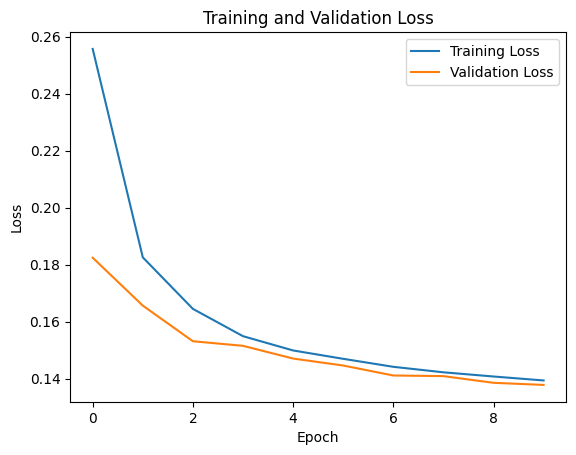

In [ ]:
fd.plot_loss()

In [ ]:
fd.evaluate()

18242/18242 ━━━━━━━━━━━━━━━━━━━━ 153s 8ms/step - accuracy: 0.9559 - loss: 0.1382
Test Loss: 0.13782893121242523
Test Accuracy: 0.9561910629272461


In [ ]:
transaction_meta = {
    'Payment Method': extended_fraud_df['Payment Method'].unique(),
    'Product Category': extended_fraud_df['Product Category'].unique(),
    'Device Used': extended_fraud_df['Device Used'].unique(),
    'Billing Shipping Address Match': extended_fraud_df['Billing Shipping Address Match'].unique(),
    'Transaction Amount': [extended_fraud_df['Transaction Amount'].min(), extended_fraud_df['Transaction Amount'].max()],
    'Quantity': [extended_fraud_df['Quantity'].min(), extended_fraud_df['Quantity'].max()],
    'Customer Age': [extended_fraud_df['Customer Age'].min(), extended_fraud_df['Customer Age'].max()],
    'Account Age Days': [extended_fraud_df['Account Age Days'].min(), extended_fraud_df['Account Age Days'].max()],
    'Transaction Hour': [extended_fraud_df['Transaction Hour'].min(), extended_fraud_df['Transaction Hour'].max()],
    'Day of Week': [extended_fraud_df['Day of Week'].min(), extended_fraud_df['Day of Week'].max()],
    'Is Fraudulent': None
}

In [ ]:
fd.input_info(transaction_meta)

-------------------------------
FEATURE INPUTS GUIDE
-------------------------------
Payment Method
-------------------------------
bank transfer
debit card
PayPal
credit card
-------------------------------
Product Category
-------------------------------
electronics
home & garden
clothing
toys & games
health & beauty
-------------------------------
Device Used
-------------------------------
tablet
desktop
mobile
-------------------------------
Billing Shipping Address Match
-------------------------------
1.0
0.0
-------------------------------
Transaction Amount
-------------------------------
0.0 - 12702.0
-------------------------------
Quantity
-------------------------------
1.0 - 5.0
-------------------------------
Customer Age
-------------------------------
0.0 - 86.0
-------------------------------
Account Age Days
-------------------------------
0.0 - 365.0
-------------------------------
Transaction Hour
-------------------------------
0.0 - 23.0
-------------------------

In [ ]:
transaction_entry = {
    'Payment Method': 'bank transfer',
    'Product Category': 'electronics',
    'Device Used': 'tablet',
    'Billing Shipping Address Match': 0,
    'Transaction Amount': 1214,
    'Quantity': 3,
    'Customer Age': 19,
    'Account Age Days': 4,
    'Transaction Hour': 22,
    'Day of Week': 4,
    'Is Fraudulent': None
}

In [ ]:
fd.input_transformer(transaction_entry, dp)

In [ ]:
fd.input_predictor()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
Transaction is likely to be fraudulent, kupal.
